In [16]:

import pandas as pd
import numpy as np
from pckgs.helper import timeseries_to_supervised, PnlCallback
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

from pckgs.models import get_model_both_sent
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sb
from pckgs.evaluator import Evaluator

from pckgs.headline_preprocess import HeadlinePreprocess

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
price = pd.read_csv('../Price/datasets/bitcoin_position_day_20_thres1.csv', parse_dates=['Timestamp'])
price.rename(columns={'Timestamp':'date'}, inplace=True)
price.set_index('date', inplace=True)
y = price.loc[:,['down', 'same', 'up']]
x1 = price.drop(['down', 'same', 'up'], axis=1)
x1

,pChange_scaled_t-1,pChange_scaled_t-2,pChange_scaled_t-3,pChange_scaled_t-4,pChange_scaled_t-5,pChange_scaled_t-6,pChange_scaled_t-7,pChange_scaled_t-8,pChange_scaled_t-9,pChange_scaled_t-10,pChange_scaled_t-11,pChange_scaled_t-12,pChange_scaled_t-13,pChange_scaled_t-14,pChange_scaled_t-15,pChange_scaled_t-16,pChange_scaled_t-17,pChange_scaled_t-18,pChange_scaled_t-19,pChange_scaled_t-20
date,,,,,,,,,,,,,,,,,,,,
2016-01-22,-0.314641,0.243533,-0.344497,-0.175584,-0.320540,0.104178,-0.986057,-0.273074,-0.263584,-0.375391,-0.248281,-0.240685,-0.279451,-0.283517,0.054100,-0.270746,-0.258634,-0.206721,-0.266842,-0.243039
2016-01-23,-0.544293,-0.314641,0.243533,-0.344497,-0.175584,-0.320540,0.104178,-0.986057,-0.273074,-0.263584,-0.375391,-0.248281,-0.240685,-0.279451,-0.283517,0.054100,-0.270746,-0.258634,-0.206721,-0.266842
2016-01-24,-0.193810,-0.544293,-0.314641,0.243533,-0.344497,-0.175584,-0.320540,0.104178,-0.986057,-0.273074,-0.263584,-0.375391,-0.248281,-0.240685,-0.279451,-0.283517,0.054100,-0.270746,-0.258634,-0.206721
2016-01-25,-0.052280,-0.193810,-0.544293,-0.314641,0.243533,-0.344497,-0.175584,-0.320540,0.104178,-0.986057,-0.273074,-0.263584,-0.375391,-0.248281,-0.240685,-0.279451,-0.283517,0.054100,-0.270746,-0.258634
2016-01-26,-0.369154,-0.052280,-0.193810,-0.544293,-0.314641,0.243533,-0.344497,-0.175584,-0.320540,0.104178,-0.986057,-0.273074,-0.263584,-0.375391,-0.248281,-0.240685,-0.279451,-0.283517,0.054100,-0.270746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,-0.244967,-0.275576,-0.280879,-0.358889,-0.006660,-0.270082,-0.211474,-0.326997,0.229818,-0.420827,-0.390958,-0.203594,-0.366132,-0.195921,-0.252316,-0.245694,-0.318273,-0.352666,-0.226903,-0.264080
2019-12-28,-0.203194,-0.244967,-0.275576,-0.280879,-0.358889,-0.006660,-0.270082,-0.211474,-0.326997,0.229818,-0.420827,-0.390958,-0.203594,-0.366132,-0.195921,-0.252316,-0.245694,-0.318273,-0.352666,-0.226903
2019-12-29,-0.208232,-0.203194,-0.244967,-0.275576,-0.280879,-0.358889,-0.006660,-0.270082,-0.211474,-0.326997,0.229818,-0.420827,-0.390958,-0.203594,-0.366132,-0.195921,-0.252316,-0.245694,-0.318273,-0.352666


In [20]:
# y2 = pd.read_csv('../Price/datasets/pChange.csv', parse_dates=['Timestamp'], index_col='Timestamp')
# y2 = y2.reindex(y.index)
# y2

In [19]:
#read headline sentiment
sentiment = pd.read_csv('../Text/datasets/headline_sentiment_mean.csv', index_col='date', parse_dates=['date'])

sentiment_score = timeseries_to_supervised(sentiment, 'sentiment_score', lag=21)
sentiment_score.dropna(inplace=True)
sentiment_score.drop('sentiment_score_t', axis=1, inplace=True)
sentiment_score = sentiment_score.reindex(y.index).ffill().bfill()

x2 = sentiment_score
x2

,sentiment_score_t-1,sentiment_score_t-2,sentiment_score_t-3,sentiment_score_t-4,sentiment_score_t-5,sentiment_score_t-6,sentiment_score_t-7,sentiment_score_t-8,sentiment_score_t-9,sentiment_score_t-10,sentiment_score_t-11,sentiment_score_t-12,sentiment_score_t-13,sentiment_score_t-14,sentiment_score_t-15,sentiment_score_t-16,sentiment_score_t-17,sentiment_score_t-18,sentiment_score_t-19,sentiment_score_t-20
date,,,,,,,,,,,,,,,,,,,,
2016-01-22,0.073593,-0.131126,-0.023412,0.016658,-0.038389,0.083144,0.087287,-0.023616,0.024484,-0.041770,-0.080686,-0.053331,-0.004431,0.059039,-0.031380,0.099493,0.120624,-0.272569,-0.021164,0.140467
2016-01-23,0.118189,0.073593,-0.131126,-0.023412,0.016658,-0.038389,0.083144,0.087287,-0.023616,0.024484,-0.041770,-0.080686,-0.053331,-0.004431,0.059039,-0.031380,0.099493,0.120624,-0.272569,-0.021164
2016-01-24,0.127320,0.118189,0.073593,-0.131126,-0.023412,0.016658,-0.038389,0.083144,0.087287,-0.023616,0.024484,-0.041770,-0.080686,-0.053331,-0.004431,0.059039,-0.031380,0.099493,0.120624,-0.272569
2016-01-25,0.015837,0.127320,0.118189,0.073593,-0.131126,-0.023412,0.016658,-0.038389,0.083144,0.087287,-0.023616,0.024484,-0.041770,-0.080686,-0.053331,-0.004431,0.059039,-0.031380,0.099493,0.120624
2016-01-26,0.002843,0.015837,0.127320,0.118189,0.073593,-0.131126,-0.023412,0.016658,-0.038389,0.083144,0.087287,-0.023616,0.024484,-0.041770,-0.080686,-0.053331,-0.004431,0.059039,-0.031380,0.099493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,-0.173105,-0.035868,-0.010401,-0.017671,-0.030418,0.044368,0.086441,-0.008117,-0.113960,-0.136853,-0.130920,-0.076284,-0.048364,-0.027700,-0.002369,-0.024807,-0.113208,-0.031633,0.058666,0.025085
2019-12-28,-0.084293,-0.173105,-0.035868,-0.010401,-0.017671,-0.030418,0.044368,0.086441,-0.008117,-0.113960,-0.136853,-0.130920,-0.076284,-0.048364,-0.027700,-0.002369,-0.024807,-0.113208,-0.031633,0.058666
2019-12-29,0.030249,-0.084293,-0.173105,-0.035868,-0.010401,-0.017671,-0.030418,0.044368,0.086441,-0.008117,-0.113960,-0.136853,-0.130920,-0.076284,-0.048364,-0.027700,-0.002369,-0.024807,-0.113208,-0.031633


In [21]:
#concat price and sentiment
x = pd.concat([x1, x2], axis=1)
x = x.values.reshape((len(x), int(len(x.columns) / 2), 2), order='F')
x.shape

(1440, 20, 2)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
print(x_train.shape)
print(x_test.shape)

y_index = y_test.index
x_index = x1.loc[x1.index < y_index[0]].index

(1152, 20, 2)
(288, 20, 2)


In [23]:
# _, _, y2_train, y2_test = train_test_split(x, y2, test_size=0.2, shuffle=False)

In [24]:
y_test_labeled = y_test.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_test_labeled = y_test_labeled.idxmax(axis=1)


y_train_labeled = y_train.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_train_labeled = y_train_labeled.idxmax(axis=1)

In [25]:
df_candle = pd.read_csv('../Price/datasets/bitcoin_candle_day.csv', header=0, parse_dates=['Timestamp'])
df_candle.rename(columns={'Timestamp':'date'}, inplace=True)
df_candle.set_index('date', inplace=True)
df_candle.rename(columns={'Open': 'open', 'Low': 'low', 'High': 'high', 'Close': 'close'}, inplace=True)
# align dates
df_candle_y = df_candle.reindex(y_index)
df_candle_x = df_candle.reindex(x_index)

In [36]:
#SIMPLE
model = get_model_both_sent()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16)                1216      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 1,267
Trainable params: 1,267
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, verbose=0, patience=60)
mc = ModelCheckpoint('model_pp.h5',verbose=0, save_best_only=True,)

history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=32,
                    # class_weight=class_weights,
                    epochs=300, callbacks=[mc, es], verbose=0)

model = load_model('model_pp.h5')

In [38]:
# es = EarlyStopping(monitor='val_classification_accuracy', mode='max', min_delta=0.001, verbose=0, patience=60)
# mc = ModelCheckpoint('model_pp.h5',verbose=1, save_best_only=True, monitor='val_classification_accuracy')
#
# history = model.fit(x=x_train, y=[y_train, y2_train], validation_data=(x_test, [y_test, y2_test]), batch_size=32,
#                     epochs=300, callbacks=[es, mc],verbose=1)#, shuffle=False)
#
# model = load_model('model_pp.h5')

<AxesSubplot:>

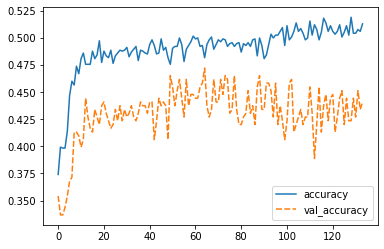

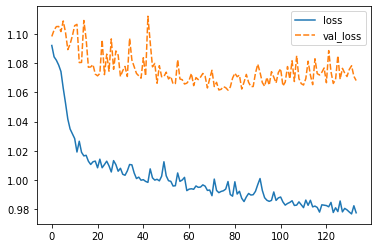

In [39]:
ac = {'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}
plt.figure()
sb.lineplot(data=ac)

loss = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
plt.figure()
sb.lineplot(data=loss)


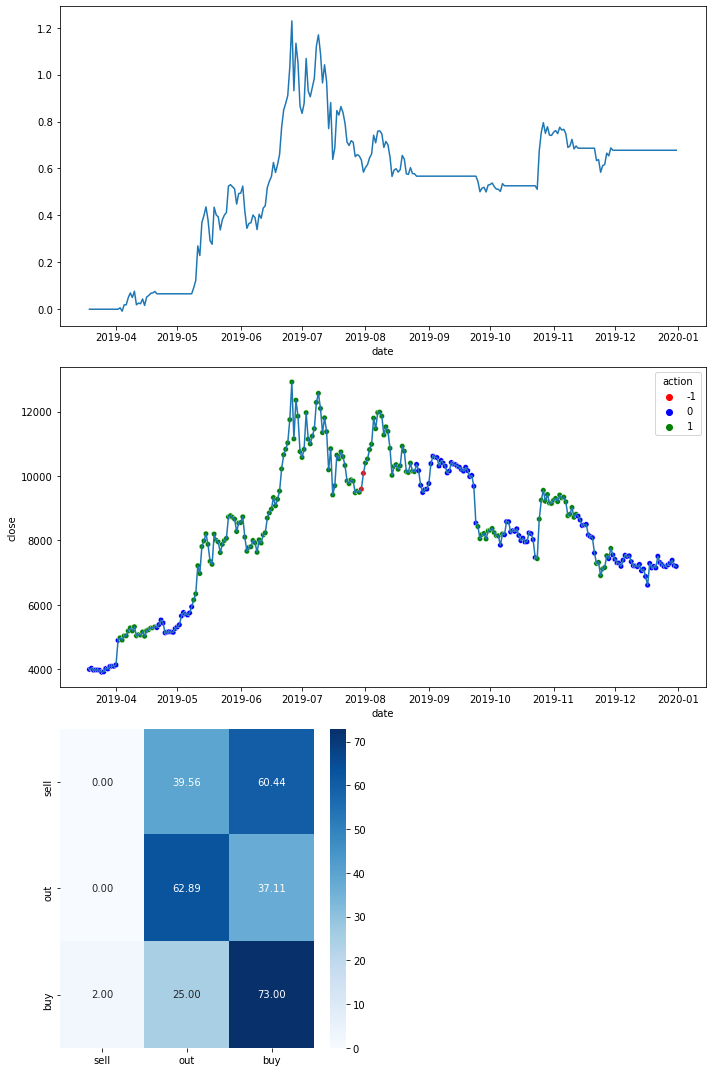

In [76]:
y_pred = model.predict(x_test)
y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=y_index)
y_pred_labeled = y_pred_labeled.idxmax(axis=1)

Evaluator.evaluate(y_pred_labeled, y_test_labeled, df_candle_y, force=False)

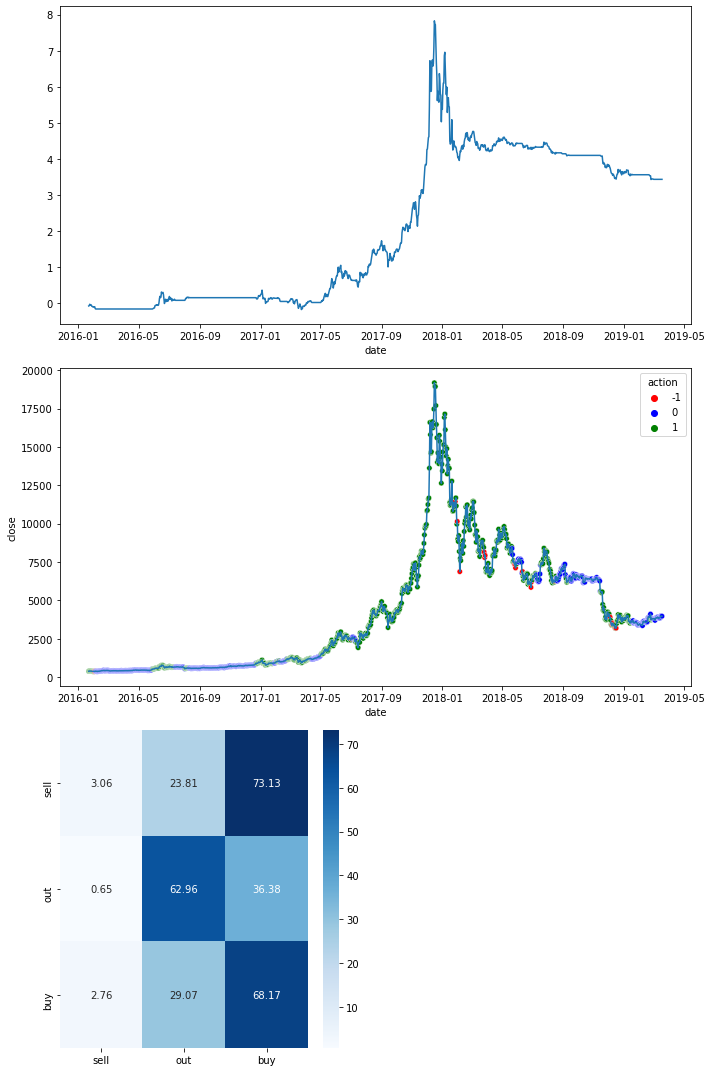

In [80]:
y_predt = model.predict(x_train)
y_predt_labeled = pd.DataFrame(y_predt, columns=[-1, 0, 1], index=x_index)
y_predt_labeled = y_predt_labeled.idxmax(axis=1)

Evaluator.evaluate(y_predt_labeled, y_train_labeled, df_candle_x, force=False)

In [35]:

print(classification_report(y_test_labeled, y_pred_labeled))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        91
           0       0.46      0.58      0.51        97
           1       0.42      0.70      0.52       100

    accuracy                           0.44       288
   macro avg       0.29      0.43      0.35       288
weighted avg       0.30      0.44      0.36       288



/home/solon/anaconda3/envs/Ptyxiaki/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

